## Задача

- Найти датасет с каггла на классификацию тестов, согласовать со мной
- Решать задачу по тому же алгоритму, что и для Classic ML, использовать те же шаблоны
- Сделать детальный анализ текста на этапе EDA
- Добавить этапы препроцессинга для текстов: токенизация, удаление пунктуации и стоп-слов
- Извлечь важные фичи из текста. Использовать count-based методы в качестве бейслайна: CountVectorizer, TFIDFVectorizer, HashingVectorizer, предварительно сделав feature engineering. Поверх них использовать Classic ML модели для классификации
- Выполнить классификацию с использованием нейросетей, использовать Tensorflow keras. Попробовать RNN, LSTM
- Сделать то же самое с использованием Pytorch (для практики)
- Попробовать использовать готовые эмбеддинги для токенов и инициализировать ими embedding слой. Посмотреть, улучшился ли результат
- Попробовать использовать предобученные модели (transformers, BERT, …). Смотреть варианты на huggingface
- Попробовать генерировать эмбеддинги для теста целиком, используя предобученные модели (в качестве этапа препроцессинга), а поверх использовать Classic ML модели. Можно так же попробовать эмбеддинги от OpenAI или любых других LLM

In [523]:
! pip install numpy pandas scikit-learn catboost matplotlib seaborn phik nltk wordcloud imblearn tensorflow

## Описание

https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

Title: title of news article

Text: body text of news article

Subject: subject of news article

Date: publish date of news article

target: target(0, 1)

In [524]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from helper import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
from plots import *

In [525]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nemow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [526]:
df = pd.read_csv('dataset.csv', index_col=0)

In [527]:
df.head(10)

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


0 - false, 1 - true

In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [529]:
df['subject'].value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

нужно прикрутить кодирование

In [530]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

Пропусков нет

In [531]:
df.duplicated().sum()

np.int64(209)

дубликатов не так уж и много

In [532]:
df = df.drop_duplicates()

df.duplicated().sum()

np.int64(0)

In [533]:
df['target'].value_counts()

target
0    23478
1    21211
Name: count, dtype: int64

датасет сбалансирован

## EDA

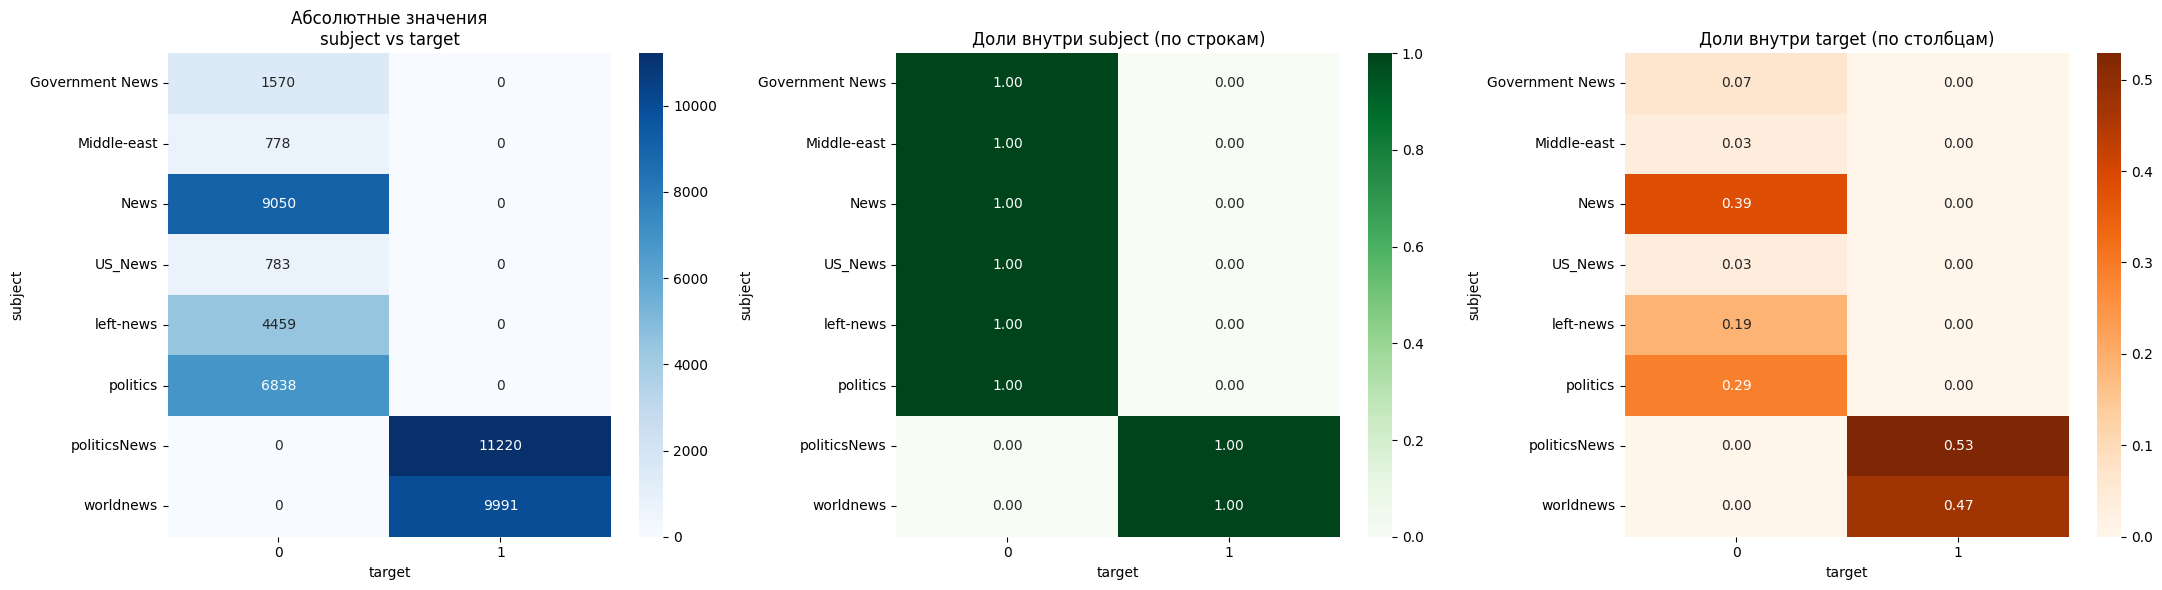

In [534]:
plot_categorical_relationship(df, 'subject', 'target')

крайне странное распределение, по какой то причине разные темы содержат только один таргет. при этом, это не ошибка склейки 2х датасетов. хотя, можно предположить что politics и politics_news, а так же news и world_news - одна категория по большому счету. в любом случае, исходя за такого распределения лучше всего избавиться от этой колонки позже

In [535]:
df['title_len'] = df['title'].fillna('').apply(lambda x: len(x.split()))

df['text_len'] = df['text'].fillna('').apply(lambda x: len(x.split()))

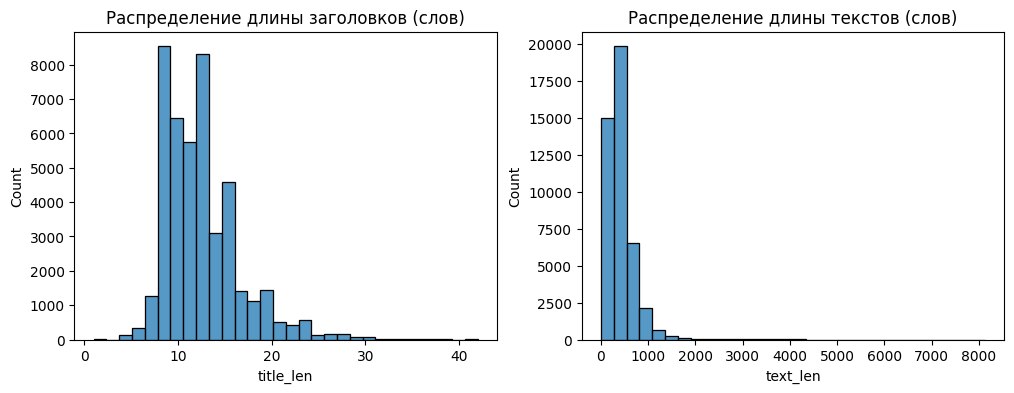

In [536]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['title_len'], bins=30, ax=axes[0])
axes[0].set_title('Распределение длины заголовков (слов)')
sns.histplot(df['text_len'], bins=30, ax=axes[1])
axes[1].set_title('Распределение длины текстов (слов)')
plt.show()

In [537]:
stop_words = stopwords.words('english')
vectorizer = CountVectorizer(max_features=30)
X = vectorizer.fit_transform(df['title'].fillna(''))

In [538]:
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

word_freq

{'about': np.int64(1959),
 'after': np.int64(2569),
 'and': np.int64(4281),
 'as': np.int64(2071),
 'at': np.int64(2256),
 'by': np.int64(1981),
 'clinton': np.int64(1791),
 'for': np.int64(7581),
 'from': np.int64(1991),
 'he': np.int64(1905),
 'hillary': np.int64(2364),
 'his': np.int64(1840),
 'house': np.int64(1999),
 'in': np.int64(9330),
 'is': np.int64(3257),
 'it': np.int64(1918),
 'new': np.int64(1776),
 'not': np.int64(1843),
 'obama': np.int64(3244),
 'of': np.int64(8157),
 'on': np.int64(6988),
 'over': np.int64(1986),
 'says': np.int64(3523),
 'the': np.int64(6842),
 'to': np.int64(17251),
 'trump': np.int64(14856),
 'video': np.int64(8505),
 'watch': np.int64(1966),
 'white': np.int64(1689),
 'with': np.int64(3965)}

топ самых популярных слов в заголовках

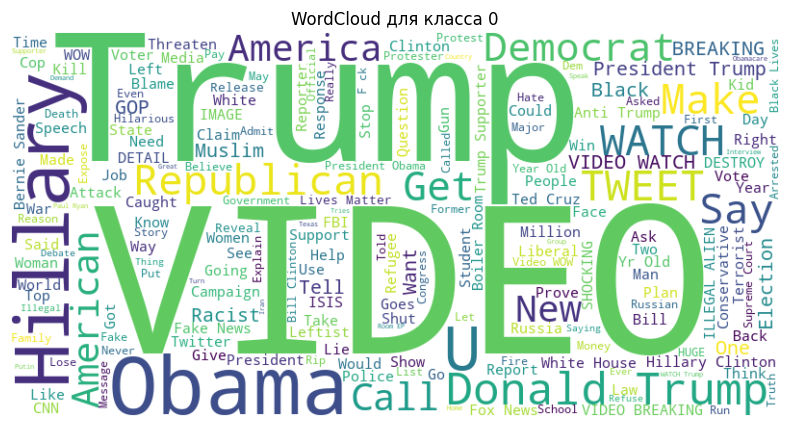

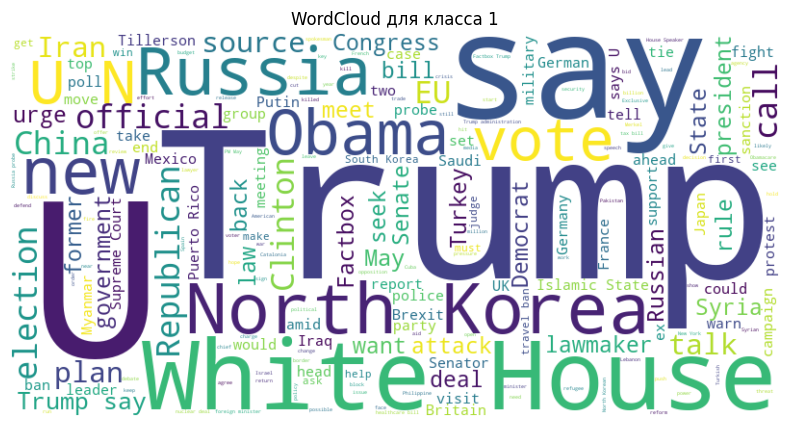

In [539]:
for cls in df['target'].unique():
    text_data = ' '.join(df[df['target'] == cls]['title'].fillna('').tolist())
    wc = WordCloud(width=800, height=400, stopwords=stop_words, background_color='white').generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud для класса {cls}')
    plt.show()

Весьма вероятно что в какой то момент времени модель столкнется с data drift, из за смены новостной повестки. поэтому, дата публикации новости бесполезна, и скорее, даже вредна. модель просто сопоставит временной промежуток и темы публикаций

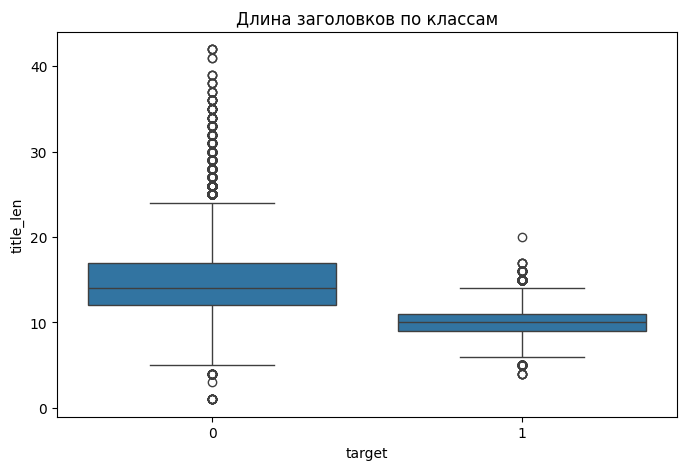

In [540]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='target', y='title_len', data=df)
plt.title('Длина заголовков по классам')
plt.show()

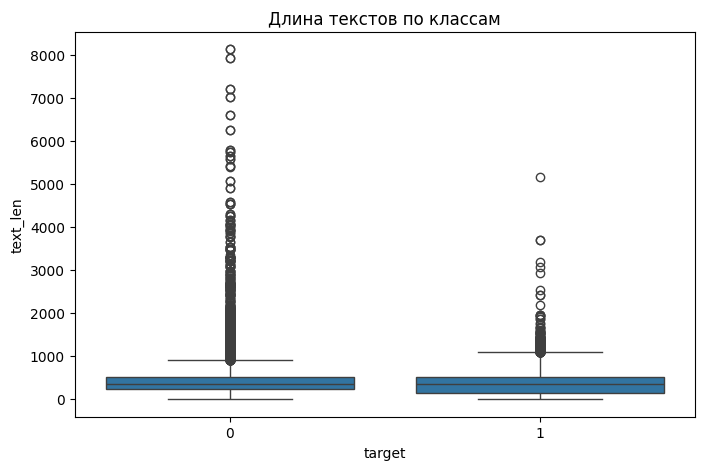

In [541]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='target', y='text_len', data=df)
plt.title('Длина текстов по классам')
plt.show()

можно заметить что в среднем правдивые новости короче

## CountVectorizer


In [542]:
df.drop(columns=['subject', 'date'], inplace=True)

In [543]:
df

,title,text,target,title_len,text_len
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0,12,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0,8,305
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0,15,580
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0,14,444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0,11,420
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1,9,466
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1,7,125
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1,7,320
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1,9,205


In [544]:
SEED = 42

In [545]:
X, y = divide_data(df, 'target')

Построим CountVectorizer модель только по телу новости и таргету

In [546]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)

y_train

7001     0
5219     0
40156    1
24280    1
42314    1
        ..
6265     0
11285    0
38335    1
860      0
15798    0
Name: target, Length: 35751, dtype: int64

In [547]:
stop_words = stopwords.words('english')
vectorizer = CountVectorizer(stop_words=stop_words, max_features=30)
X_train_text = vectorizer.fit_transform(X_train['text'].fillna(''))
X_test_text = vectorizer.fit_transform(X_test['text'].fillna(''))

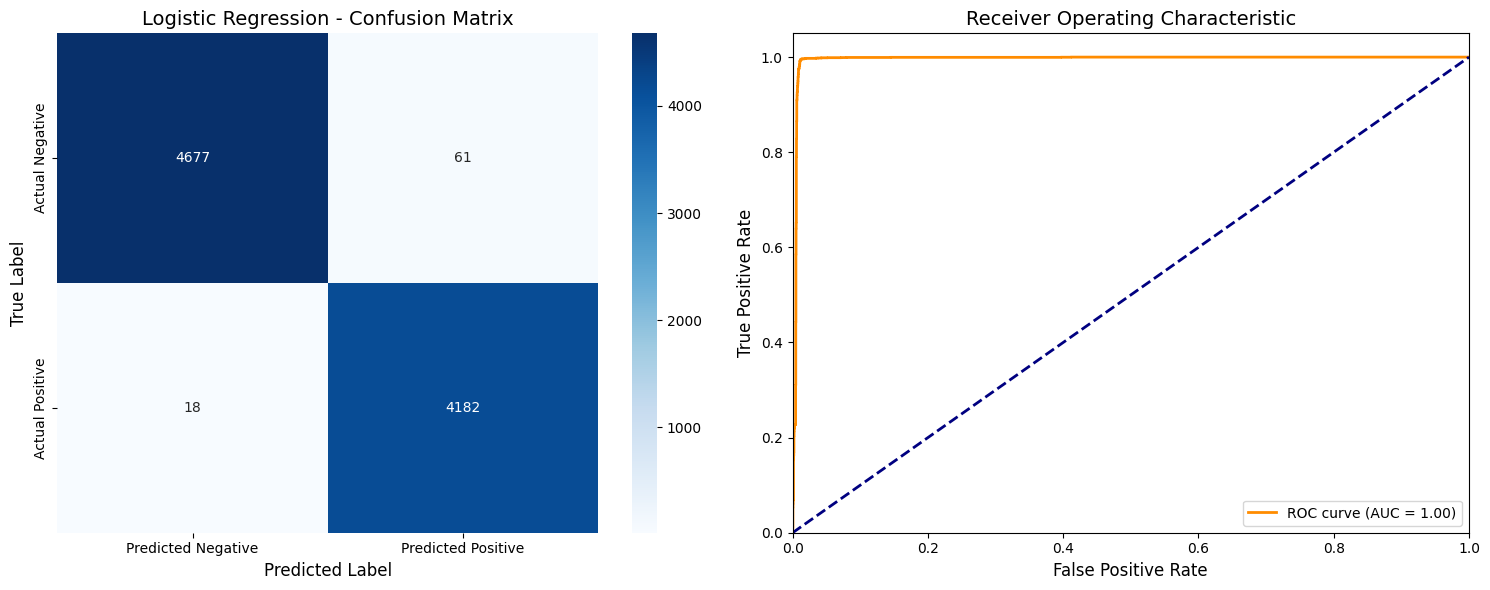


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9952
Average Precision 0.9880
         F1 Score 0.9911
        Precision 0.9909
           Recall 0.9914
         Accuracy 0.9912


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.985623 0.995714
Negative   0.996166 0.987125



In [548]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')

log_reg.fit(X_train_text, y_train)

y_pred = log_reg.predict(X_test_text)
y_probs = log_reg.predict_proba(X_test_text)[:, 1]  

text_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

модель по тексту новости выше

In [549]:
X_train_title = vectorizer.fit_transform(X_train['title'].fillna(''))
X_test_title = vectorizer.fit_transform(X_test['title'].fillna(''))

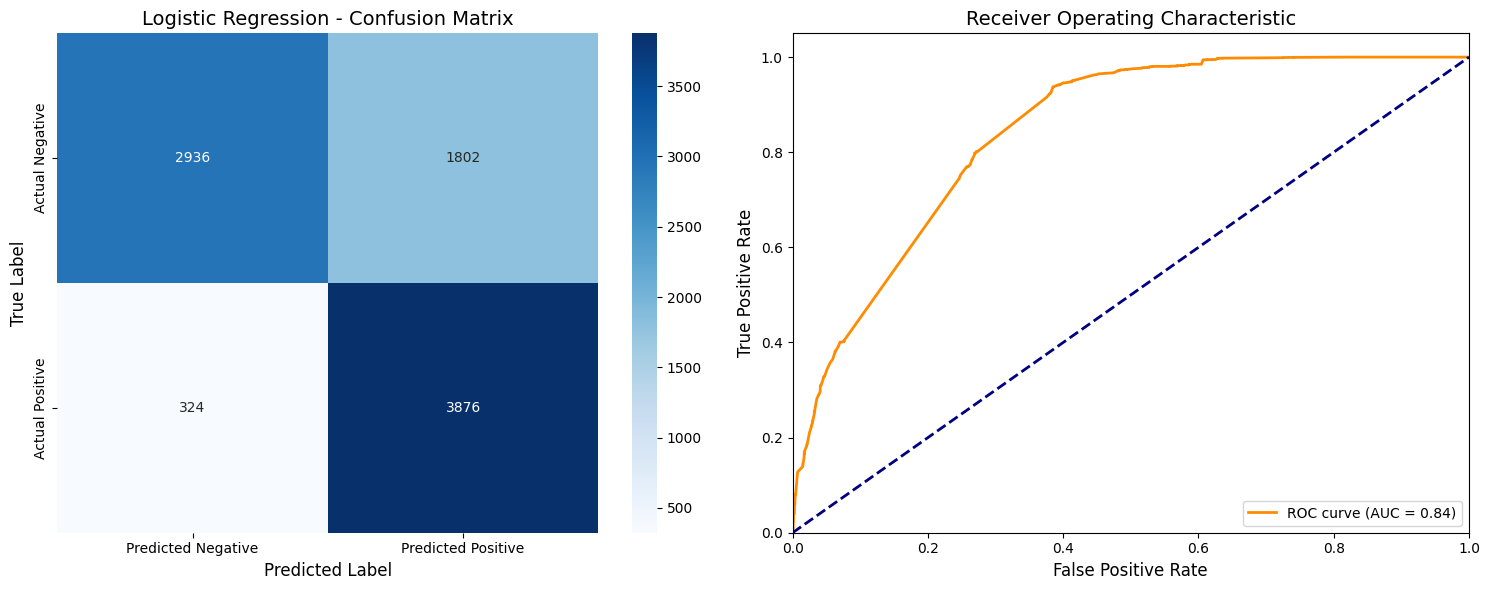


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.8433
Average Precision 0.7819
         F1 Score 0.7595
        Precision 0.7916
           Recall 0.7713
         Accuracy 0.7621


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.682635 0.922857
Negative   0.900613 0.619671



In [550]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')

log_reg.fit(X_train_title, y_train)

y_pred = log_reg.predict(X_test_title)
y_probs = log_reg.predict_proba(X_test_title)[:, 1]  

title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

Модель построенная только от текста намного лучше той, что строится только от заголовка. далее буду строить модели только по заголовкам, т.к. модель по тексту уже дает почти идеальный результат

## TfidfVectorizer

In [551]:
X_train.drop(columns=['title_len', 'text_len', 'text'], inplace=True)

X_test.drop(columns=['title_len', 'text_len', 'text'], inplace=True)

X_train = X_train["title"]
X_test = X_test["title"]


X_train

7001      Trump’s Own Children Won’t Be Voting For Him ...
5219      Crowd Erupts In Boos When Military Mom Asks P...
40156    Factbox: Malaysia 2018 budget seen lifting cas...
24280    Trump wants $4 billion more for missile defens...
42314    Turkey will deal with Iraqi central government...
                               ...                        
6265      Hillary’s Message To Former Miss Universe Cal...
11285    SENIOR CIA INTEL: “Wiretapping of Trump Transi...
38335    Gala glitz masks Asia's tensions as Trump wind...
860       Trump Stole An Idea From North Korean Propaga...
15798    WATCH JUDGE TELL DISRESPECTFUL GANGBANGER Taxp...
Name: title, Length: 35751, dtype: object

In [552]:
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear'))
])

In [553]:
tfidf_pipe.fit(X_train, y_train)

y_pred = tfidf_pipe.predict(X_test)
y_probs = tfidf_pipe.predict_proba(X_test)[:, 1]  

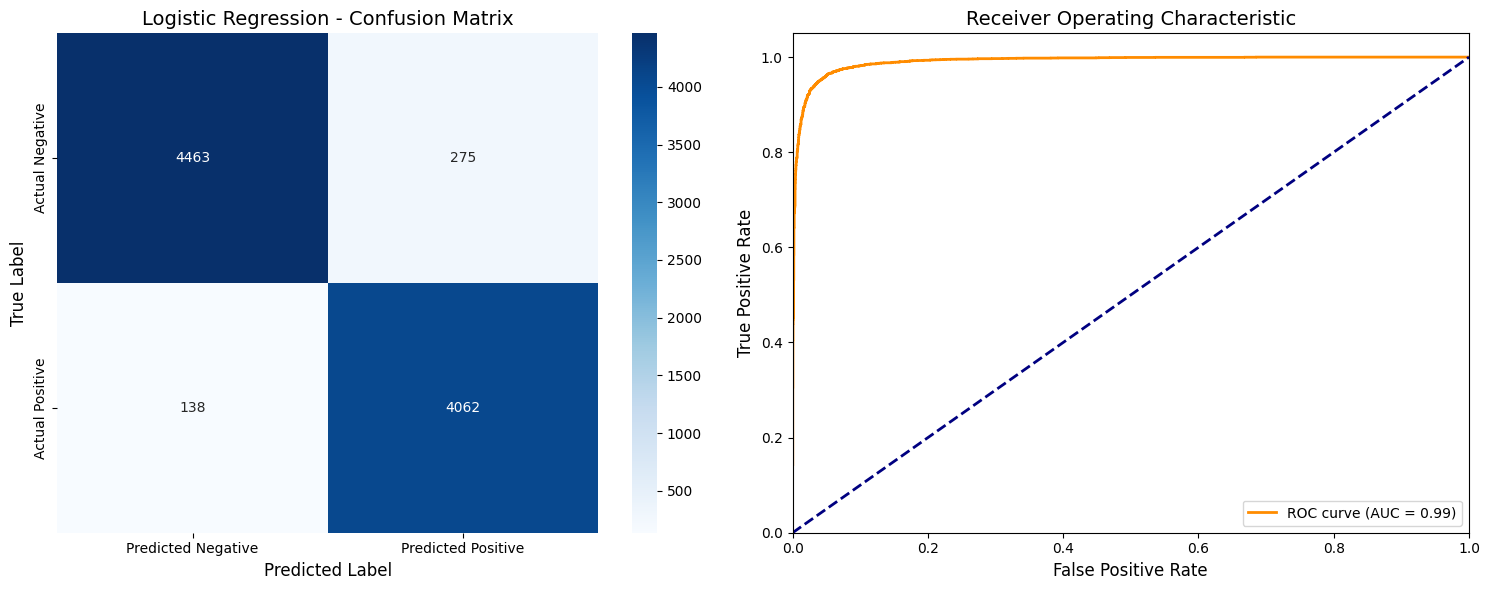


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9908
Average Precision 0.9896
         F1 Score 0.9537
        Precision 0.9533
           Recall 0.9546
         Accuracy 0.9538


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.936592 0.967143
Negative   0.970007 0.941959



In [554]:
tfidf_title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

Намного лучше чем CountVectorizer

## HashingVectorizer

In [555]:
hashing_pipe = Pipeline([
    ('hashing', HashingVectorizer()),
    ('logreg', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear'))
])

In [556]:
hashing_pipe.fit(X_train, y_train)

y_pred = hashing_pipe.predict(X_test)
y_probs = hashing_pipe.predict_proba(X_test)[:, 1]  

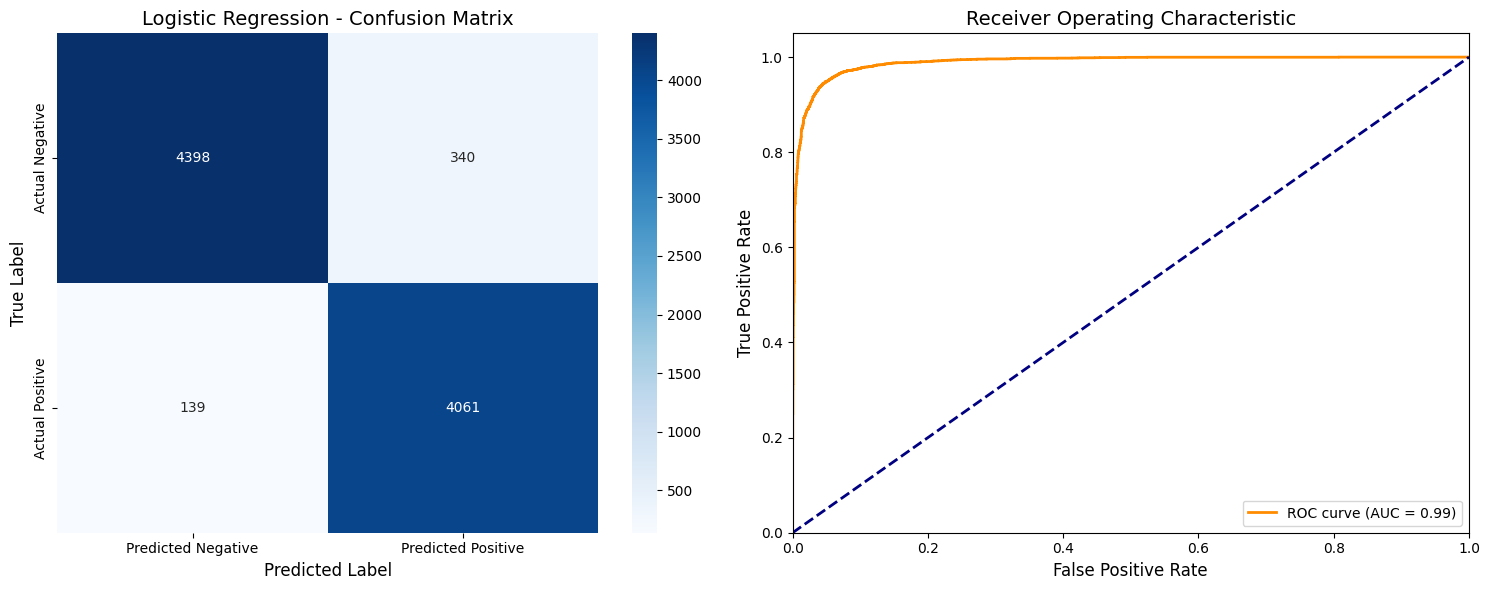


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9887
Average Precision 0.9871
         F1 Score 0.9463
        Precision 0.9461
           Recall 0.9476
         Accuracy 0.9464


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.922745 0.966905
Negative   0.969363 0.928240



In [557]:
hashing_title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

примерно на том же уровне что и TFIDF